# Implementing PageRank from scratch

*This notebook follows a similar approach as [the slides](http://web.stanford.edu/class/cs246/slides/09-pagerank.pdf) and [book](http://infolab.stanford.edu/~ullman/mmds/ch5.pdf) of the course "Mining Massive Data Sets" from Jure Leskovec. I attempt to follow closely his notation.*

In this notebook I will implement from scratch the PageRank algorithm that the founders of Google proposed (Bringing Order to the Web, 1998) to rank (order) the results of our google searches. Google was not the first search engine, but it was the first at utilising both the content of the webpage and the importance of the webpage in the huge graph containing all the webpages.

How can one define importance of a webpage or equivalently the importance of a node in a graph? In the PageRank algorithm the importance of a webpage depends on how many other webpages link to that webpage. Also, if an important webpage links to you, then you are considered important too. While all these might sound abstract we can define importance of webpage (node) $j$ as:
$$
r_j = \sum_{i \rightarrow j} \dfrac{r_i}{d_i}
$$
where $d_i$ is the out-degree of node $i$ and $i \rightarrow j$ includes all the nodes $i$ that point to node $j$.

Some takeaways from the above equation:
* Your importance depends on the importance of your incoming links, which gives a recursive flavour to our definition
* You divide equally your importance (vote) to all the nodes you point to
* The more important you are the more important your outgoing votes are

In [53]:
import numpy as np
import matplotlib.pyplot as plt

## Ideal Internet Graph

We will start by having an ideal internet graph that does not contain any dead-ends or spider traps (more on that later) to get the basic and super elegant idea of PageRank. We will then gradually lift these assumptions and build the full PageRank algorithm that could be used on any graph of any size efficiently.

![PageRank](img/ideal_graph.png)

*Note:* The above matrix is called stochastic since all of its columns sum to 1. It can also be called transition matrix.

In [8]:
# A simple ideal stochastic ajacency matrix
M = np.array([
    [0.5, 0.5, 0],
    [0.5, 0, 1],
    [0, 0.5, 0]
])

# A prior starting distribution
r_start = np.array([0.2, 0.6, 0.2])

We want to solve the equation $r = Mr$. This looks similar to the equation $Ax = λx$ which we solve in order to find the eigenvectors of $A$. So, $r$ is the eigenvector of $M$ with eigenvalue 1. We can easily find this eigenvector through the power iteration where $r^{(t+1)} = Mr^{(t)}$.

In [22]:
max_iterations = 20
r_old = r_start
history = [r_start]

for _ in range(max_iterations):
    # Find the new r
    r_new = M @ r_old
    
    # Save the history of updates
    history.append(r_new)
    
    # Update r_old
    r_old = r_new
    
print(r_new)

[0.39920254 0.40208778 0.19870968]


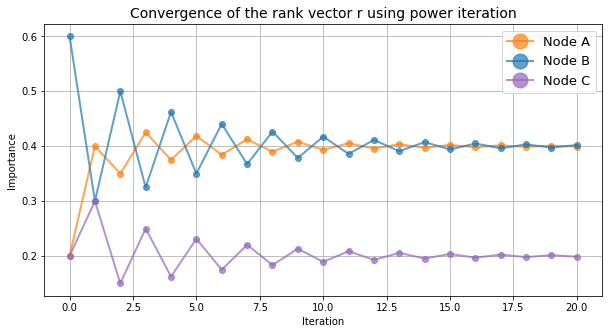

In [33]:
history = np.array(history)
def plot_history(history):
    fig = plt.figure(figsize=(10, 5))

    plt.plot(np.arange(len(history)), history[:, 0], label="Node A", color="tab:orange", alpha=0.7, linewidth=2, marker='o')
    plt.plot(np.arange(len(history)), history[:, 1], label="Node B", color="tab:blue", alpha=0.7, linewidth=2, marker='o')
    plt.plot(np.arange(len(history)), history[:, 2], label="Node C", color="tab:purple", alpha=0.7, linewidth=2, marker='o')

    plt.legend(prop={'size': 13}, markerscale=2.5)
    plt.xlabel("Iteration")
    plt.ylabel("Importance")
    plt.grid()
    plt.title("Convergence of the rank vector r using power iteration", fontsize=14)
    plt.show()
    
plot_history(history)

Our algorithm converges and it seems like nodes A and B are equally important with an importance of 0.4 and node C does not seem important with an importance of 0.2. This intuitevely makes sense since node C has only one incoming link when compared to A and B that have two.

## Dead-ends and spider traps

The super simple and small example above is also ideal. This means that in order for a unique r (stationary distribution) to exist the graph satisfied two requirements:
* No dead ends
* No spider traps, for example $a \rightarrow b \leftrightharpoons c$ has a trap since if we go from a to b we can never go back to a again.

Intuitevely the problem with the spider traps makes sense, since what we are actually doing is letting a surfer infinetely surf on our nodes and at each time $t$ we ask on which node the surfer currently is. By collecting an infinite number of answers we form the stationary distribution $r$. So, if our surfer gets trapped (which is certain since the surfer performs infinite steps), it will never visit again the rest of the graph.

Let's first create **a dead-end** on our previosly ideal graph.

In [34]:
# A not so stochastic ajacency matrix due to a dead end
M = np.array([
    [0.5, 0.5, 0],
    [0.5, 0, 0],
    [0, 0.5, 0]
])

# A prior starting distribution
r_start = np.array([0.2, 0.6, 0.2])

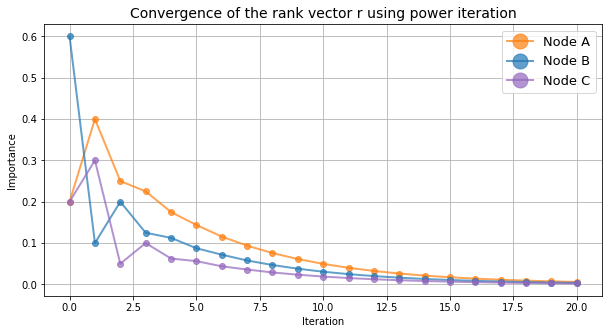

In [42]:
max_iterations = 20
r_old = r_start
history = [r_start]

for _ in range(max_iterations):
    # Find the new r
    r_new = M @ r_old
    
    # Save the history of updates
    history.append(r_new)
    
    # Update r_old
    r_old = r_new
    
plot_history(np.array(history))

We notice that all the nodes converge to an improtance of 0. Our surfer has nowhere to go when it reaches the dead-end at node C, so she "vanishes". This means that the total importance of the graph leaks out.

Now we create **a spider trap**.

In [43]:
# A stochastic ajacency matrix with a spider trap
M = np.array([
    [0.5, 0, 0],
    [0.5, 0, 1],
    [0, 1, 0]
])

# A prior starting distribution
r_start = np.array([0.2, 0.6, 0.2])

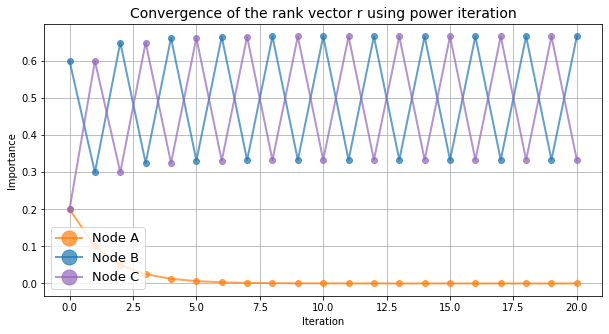

In [44]:
max_iterations = 20
r_old = r_start
history = [r_start]

for _ in range(max_iterations):
    # Find the new r
    r_new = M @ r_old
    
    # Save the history of updates
    history.append(r_new)
    
    # Update r_old
    r_old = r_new
    
plot_history(np.array(history))

We created a spider trap between node B and C. As a result the surfer is trapped on that neighborhood which absrobs all the importance. After infinite steps she will never visit again node A and also the importance of node B and C will constantly oscillate.

These two problems presented above occur on many webpages and force us to patch our above implementation.

## Fixing the dead ends and traps

First, we will solve the problem of spider-traps and the solution of dead-ends will come naturally. The PageRank paper suggests that our surfer can now teleport on any node with a probability of $1 - β$ where $β$ is a user defined variable (usually around 0.8 - 0.9). This means that if our surfer gets trapped, after some steps it will manage to teleport and possibly escape the trap.

Similarly, in the case of dead-ends the surfer will always teleport at its next step. This means that our previously stochastic adjacency matrix remains stochastic since its dead-end column now sums to 1.

Our new rule for calcualting the importance of a single node $j$ becomes:
$$
r_j = \sum_{i \rightarrow j} β \dfrac{r_i}{d_i} + (1-β)\dfrac{1}{N}
$$
and as a result of the power iteration method, $r=Mr$ becomes $r=Ar$ where $A$ is given by:
$$
A = βM + (1-b)\left( \frac{1}{N} \right) _{NxN}
$$

In [ ]:
# A stochastic ajacency matrix with a spider trap
M = np.array([
    [0.5, 0, 0],
    [0.5, 0, 1],
    [0, 1, 0]
])

# A prior starting distribution
r_start = np.array([0.2, 0.6, 0.2])

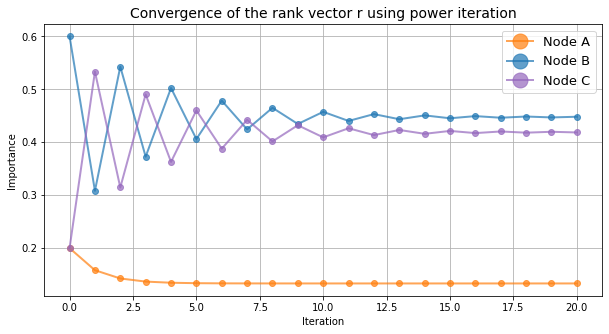

In [51]:
beta = 0.75  # This means that the probability of teleporting is high (approximately 1 teleport every 4 steps). Normally beta is around 0.85
N = np.full((len(M), len(M)), 1 / len(M))

max_iterations = 20
r_old = r_start
history = [r_start]

for _ in range(max_iterations):
    # Find the new r
    A = beta * M + (1 - beta) * N
    r_new = A @ r_old
    
    # Save the history of updates
    history.append(r_new)
    
    # Update r_old
    r_old = r_new
    
plot_history(np.array(history))

We succesfully dealt with the spider trap and we can see that our power iteration method converged giving the final importance to our nodes. In the case of google page ranking, this means that in the list of search results we would first present webpage B then C and finally A.

I do not present the results of dealing with the dead ends but you can imagine that we manually add on each dead end node an outgoing edge to all the nodes of our graph.

## Surfing and Markov Chains

In case you are familiar with the theory behind Markov chains you can find a direct comparison between them and PageRank. Briefly, a Markov chain describes an event that depends only on the exact previous event. For example, if our surfer went to webpages A->B->C the next webpage depends only on webpage C. The probability of going from C to another webpage is given to us from the tranisition matrix $M$, which we have presented above as the stochastic adjacency matrix.

In our case we have made one strong assumption, that the probability of surfing from webpage A to any outgoing link is equal to $\dfrac{1}{d_A}$ where $d_A$ is the number of outgoing links. This means that our surfer randomly selects one of the possible outgoing links.

Finally, the principal eigenvector that we find above using the power iteration method is called **stationary vector** and is **unique** for a given matrix $M$ if that matrix follows some rules such as:
* Each column sums to 1 (stochastic)
* No spider traps
* No dead-ends

I believe that this gives a more sound (and definetely simplified) approach as to why we must deal with dead-ends and spider traps.

## Scaling issues

You might suspect that the whole internet does not include only 3 webpages A, B, C. Actually, the estimated number of webpages is around 1.7 billion. Our algorithm needs to keep on each iteration a vector for `r_new`, a vector of `r_old` and the adjacency matrix M or A. `r_new` and `r_old` contain 1.7 billion float entries each which results to $2 * 1.7 * 10^9 * 4$ bytes = 13.6GB which I believe can easily fit the memory of the Google machines. Our main problem however is the size of M, A. They both have the same size $NxN$ where N is the number of total webpages. This means that in order to fit one of these matrices we need $(1.7 * 10^9)^2*4$ bytes ~  14*10^6TB. Well that seems pretty big and probably not even google would be able to store that matrix.

Some good and some bad news. The good news are that the matrix M (the ideal one) is sparse and can be stored and loaded efficiently. Assuming that there are on average 10 outgoing links per page this means we need $1.7 * 10^9 * 4 * 10$ bytes ~ 68GB so in total we need $r_{old} + r_{new} + M = 81.6GB$. Yay, this soudns reasonable enough and we can store it easily on a single Google machine. However, the bad new are that the matrix M can be used only in the ideal scenario that the graph of all the webpages does not include any spider traps or dead-ends as we showed above.

In the more realistic scenario there are many dead-ends and spider traps, so we must use the matrix A instead of matrix M. Well, matrix A is not sparse at all and actually has almost no 0 values. This means that we actually need 14million TB to perform the power iteration. Fortunately, there is a way to get back to using the sparse matrix M which can also include traps and dead-ends. 

## Fixing our issues, again

Assuming no dead end, we could rerwite our power iteration rule $r = \left(βM + (1-b)\left( \frac{1}{N} \right)_{NxN}\right)r$ to $r = βMr + \left( \frac{1 - b}{N} \right)_{N}$. Instead of adding an NxN full matrix to M, we instead add an N sized vector to the final result. With the above rewrite we have avoided using the dense matrix A. 

Now, we must also deal with the dead-ends. As you remember in the case of dead-ends there was a leak of importance. We can quantify the total leak (from both the dead-ends and the random teleportations) as $1 - S$ where $S = \sum_jr_j'$ and $r_j'$ is the importance of node j without caring about possible teloportation that ended up on node j.

![PageRank](img/pagerank_full.png)

*[Image from Yure's Leskovec slides](http://web.stanford.edu/class/cs246/slides/09-pagerank.pdf)*

I had two main difficulties understanding the above algorithm. First, what is the S? Second, where did the 1 - b go? In the case that we did not have any dead-ends S == 1 - b and the equation takes the form we presented above. In the case of dead ends S is b - dead end leaks, so the numerator becomes 1 - b + dead_end_leaks and we have accounted for both spider-traps and dead ends while using the sparse matrix M.

Below, we show the implementation of the final version of our PageRank algorithm.

In [ ]:
# A stochastic adjacency matrix with a spider trap
M = np.array([
    [0.5, 0, 0],
    [0.5, 0, 1],
    [0, 1, 0]
])

# A prior starting distribution
r_start = np.array([1/3, 1/3, 1/3])

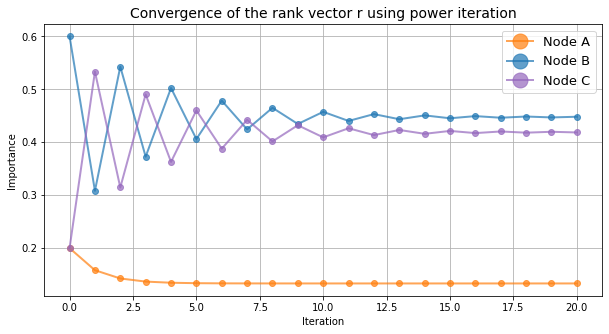

In [52]:
beta = 0.75
N = np.full((len(M), len(M)), 1 / len(M))

max_iterations = 20
r_old = r_start
history = [r_start]

for _ in range(max_iterations):
    # Find the new r'
    r_prime = beta * M @ r_old  # We only use matrix M and avoid calculating the dense matrix A
    
    # Calculate the residual (leak) from dead ends and random teleports
    leak = 1 - np.sum(r_prime)
    
    # Calcualte r_new
    r_new = r_prime + (1 / len(r_prime)) * leak
    
    # Save the history of updates
    history.append(r_new)
    
    # Update r_old
    r_old = r_new
    
plot_history(np.array(history))

We got the exact same results as in the case above while we avoided using the dense matrix A. We have successfully created a method that will be able to rank the importance of pages regardless of the graph size and relatively fast. Approximately, even for the biggest graphs (many billions of nodes) the power iteration method converges at ~50 iterations.

$$
The \hspace{1mm} End!
$$